In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import math
import random 
from scipy import stats
import math 
import seaborn as sns 
import astropy.stats
import statistics

In [2]:
#this makes it so that the WHOLE dataframe prints - will crash your browser if used too liberally 
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

In [3]:
random.seed(1)

#### Load the data

In [4]:
#columns that aren't needed 
drop_cols = ['Unnamed: 0', 'Allowed', 'Subject', 'StudioVersion', 
             'leftarrow', 'rightarrow', 'triggercode', 'Clock.Information', 
             'DataFile.Basename', 'Display.RefreshRate', 'Procedure[Block]', 
             'Procedure[Trial]', 'RandomSeed', 'Running[Block]', 
             'Running[SubTrial]', 'Running[Trial]', 'RuntimeCapabilities', 
             'RuntimeVersion', 'RuntimeVersionExpected']


SST_cleaned_7231.csv is the trial by trial event data that's been run through clean_SST.ipynb

In [5]:
SST_concat = pd.read_csv('SST_cleaned_7231_all_rows_all_columns.csv').drop(drop_cols, 
                                                      axis =1)

/Users/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,15,38,82,105,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### A few qa checks: 

In [6]:
#check these values - they shouldn't be over 1000ms 
sum(SST_concat['go_stim_duration'] > 1000)

0

In [7]:
#check len of dataframe to make sure it all got loaded 
assert len(SST_concat) == 2603160

### Issue 1:  Different go stimulus duration across 

##### On go trials, the go Stimulus is displayed for 1000ms, or RT, whichever comes first. On stop trials, the go stimulus is displayed for the duration of the stop signal delay (range: 0ms - 900ms), or RT, whichever comes first. 

In [8]:
#use groupby method to do computations within participants 
group_narguid = SST_concat.groupby('NARGUID')

In [9]:
narguid_stop_duration = group_narguid.apply(lambda x: 
                                            np.mean(x.loc[x['trial_type'] == 'StopTrial']
                                            ['go_stim_duration']))

In [10]:
narguid_stop_duration[:10] #preview of a few of these 

NARGUID
003RTV85    314.083333
00CY2MDM     71.933333
00HEV6HB    161.483333
00LJVZK2    235.950000
00NPMHND    491.583333
00R4TXET    218.333333
00UMK5VC    258.633333
00X2TBWJ    307.866667
010ZM3H9     16.333333
0191C80U    159.166667
dtype: float64

In [11]:
narguid_go_duration = group_narguid.apply(lambda x: 
                                          np.mean(x.loc[x['trial_type'] == 'GoTrial']['go_stim_duration']))

In [12]:
narguid_go_duration[:10] #preview 

NARGUID
003RTV85    647.570000
00CY2MDM    492.936667
00HEV6HB    463.266667
00LJVZK2    767.306667
00NPMHND    803.490000
00R4TXET    493.933333
00UMK5VC    580.193333
00X2TBWJ    582.603333
010ZM3H9    493.036667
0191C80U    605.026667
dtype: float64

##### Figure 2. Histogram of Go Stimulus Durations on Go and Stop Trials

In [13]:
len(SST_concat.loc[(SST_concat['trial_type'] == 'StopTrial') & (SST_concat['go_stim_duration'] == 0)]) / \
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

0.07796524224404186

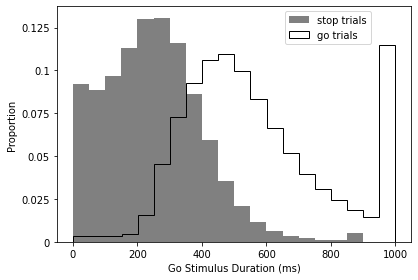

(None,)

In [14]:
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna(), density=True,
          label = "stop trials", color = 'grey', bins = 18)
plt.xlabel('Go Stimulus Duration (ms)')
plt.ylabel('Proportion')

plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'].dropna(), density=True,
         histtype='step', 
         label = "go trials", color = 'black', bins = 20)
leg = plt.legend( loc = 'upper right')
plt.draw() 
plt.tight_layout()
ax = plt.gca()
# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# change legend - from stackoverflow 
xOffset = .1
bb.x0 -= xOffset
bb.x1 -= xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
#edit the ticks so that they integrate over the whole bin 
mod_ticks = mtick.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 50))
ax.yaxis.set_major_formatter(mod_ticks)
plt.savefig('go_stim_duration.png', dpi=300)

plt.show(), 

Difference of average participant go duration on go trials and stop trials

In [15]:
np.mean(narguid_go_duration) - np.mean(narguid_stop_duration)

340.6331825934649

let's look at the averages by participant now: 

##### Comparing stop failure reaction time and overt go response reaction time is a conservative indication of whether context independence, a necessary assumption when modeling stop signal reaction time is being violated.  

In [16]:
narguid_average_stop_rt = group_narguid.apply(lambda x: 
                                                np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))

In [17]:
print('stop failure rt:', np.mean(narguid_average_stop_rt))
print('sdev:', np.std(narguid_average_stop_rt))   

stop failure rt: 456.0738969888373
sdev: 110.01419156123704


In [18]:
narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') 
                                                                    & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))

In [19]:
print('overt go response mean:', np.mean(narguid_average_go_rt))
print('sdev:', np.std(narguid_average_go_rt))

overt go response mean: 543.6630781157475
sdev: 95.29722256609477


In [20]:
print('difference beween these:', np.mean(narguid_average_stop_rt) - np.mean(narguid_average_go_rt))

difference beween these: -87.58918112691015


##### Compare stop failure rt and go rt within participants: 

In [21]:
#get number of participants who have longer stop failure rt
print(sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)))

#divide by number of participants
sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / len(SST_concat['NARGUID'].unique())

447


0.06181717604757295

##### Another way that shorter go stimulus durations can effect the go process is in the choice response

In [22]:
def stop_fail_accuracy(df):
    try: 
        acc = len(df.loc[df['correct_stop_mapping'] == 1]) / len(df.loc[df['correct_stop'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    return acc                                         

In [23]:
#make a dataframe of rts 
narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt,'go_rt':narguid_average_go_rt})

#add accuracies to that dataframe
narguid_df['stop_acc'] = np.NaN
narguid_df['go_acc'] = np.NaN

narguid_df['go_acc'] = group_narguid.apply(lambda x: len(x.loc[x['correct_go_response'] == '1.0']) /
                                          len(x.loc[(x['correct_go_response'] != 'omission') & (x['trial_type'] == 'GoTrial')]))

narguid_df['stop_acc'] = group_narguid.apply(lambda x: stop_fail_accuracy(x))

#if a participant had no stop failures, then they need to be dropped 
narguid_df = narguid_df.dropna(how='any')

calculate CI for the difference between go_rt and stop_rt

In [24]:
mu = np.mean(narguid_df['go_rt'] - narguid_df['stop_rt'])
N = len(narguid_df)
sigma = np.std(narguid_df['go_rt'] - narguid_df['stop_rt'])
stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N))


(86.0019642142821, 89.20067124411527)

calculate CI for the difference between stop_acc and go_acc

In [25]:
mu = np.mean(narguid_df['stop_acc'] - narguid_df['go_acc'])
N = len(narguid_df)
sigma = np.std(narguid_df['stop_acc'] - narguid_df['go_acc'])
stats.norm.interval(.95, loc=mu,scale=sigma/math.sqrt(N))

(-0.11187416423722574, -0.10639848790163689)

##### choice accuracy across SSDs 

In [26]:
ssd_acc_df = group_narguid.apply(lambda x: x.groupby('SSDDur').apply(lambda x: stop_fail_accuracy(x))) 
#this actual returns a series - misleading variable name

In [27]:
average_ssd_acc = ssd_acc_df.groupby('SSDDur').apply(lambda x: np.mean(x))

In [28]:
sem_ssd_acc = ssd_acc_df.groupby('SSDDur').apply(lambda x: stats.sem(x, nan_policy = 'omit'))

##### Figure 3. Choice response accuracy on stop-failure trials across SSD


In [29]:
std_ssd_acc = ssd_acc_df.groupby('SSDDur').apply(lambda x: np.std(x))

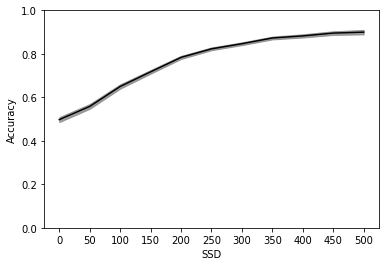

In [30]:
plt.plot(average_ssd_acc.iloc[:-8], color='black')

plt.fill_between(x = average_ssd_acc.index[:-8], y1=average_ssd_acc.iloc[:-8]-(1.96*sem_ssd_acc.iloc[:-8]), 
                 y2=average_ssd_acc.iloc[:-8]+(1.96*sem_ssd_acc.iloc[:-8]), color='grey', alpha=.75)

plt.yticks(np.arange(0,1.2,.2))
plt.xticks(np.arange(0, 550, 50))
plt.ylabel('Accuracy')
plt.xlabel('SSD')
plt.savefig('accuracy_accross_ssd.png', dpi=300)
plt.show()

### Issue 2: Go Stimulus sometimes not presented

On trials where SSD is 0, the Go stimulus is not presented. 

In [31]:
len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

0.09017194486700779

The stop accuracy of these should be high, due to the stop process not being handicapped. 

In [32]:
def zero_SSD_acc(df): 
    try: 
        acc = len(df.loc[(df['SSDDur'] == 0) & (df['correct_stop'] == 1.0)]) / len(df.loc[df['SSDDur'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    
    return acc                     

In [33]:
zero_acc = group_narguid.apply(lambda x: zero_SSD_acc(x))

In [34]:
np.mean(zero_acc)

0.6045009332058497

##### Figure 4. Histogram of Stop-Signal Delays   


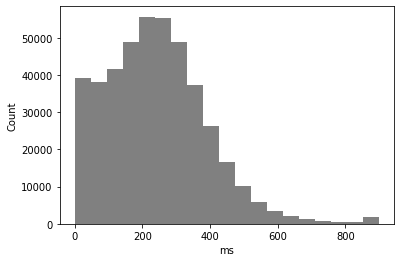

In [35]:
plt.hist(SST_concat['SSDDur'].dropna(), bins = len(SST_concat['SSDDur'].dropna().unique()), color='grey')
plt.xlabel('ms') #fix xlabel, ylabel 
#plt.title('Distribution of Stop Signal Delays')
plt.ylabel('Count')
#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
#plt.legend()
plt.savefig('stop_signal_duration_hist.png', dpi=300)
plt.show() 

### Issue 3: Faulty stop-signal delays

If a response faster than 50ms is made on a trial where SSD is 50, then all following stop trials will have that RT and be stop failure trials. 

In [36]:
#uncomment to look at the relevant columns 
# SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]\
#      [['NARGUID', 'TrialNum', 'SSD.RT', 'SSD.RESP', 'SSDDur' ]]

In [37]:
SSD_bug = SST_concat.loc[(SST_concat['SSD.RT'] < 50) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID']# \

In [38]:
#uncomment to print to a csv and view 
# pd.DataFrame(SSD_bug.unique()).to_csv('SSD_bug.csv')

In [39]:
len(SSD_bug.unique())/ 7231  #percent of subjects with this issue 

0.027243811367722307

In [40]:
len(SSD_bug) / len(SST_concat) #percent of trials this impacts 

0.0021101276909602177

In [41]:
#drops the prob narguids and regroups by SSD
drop_zero_ssd_group = SST_concat.set_index('NARGUID').drop(SSD_bug.unique()).groupby('NARGUID')

Recalculate accuracy with these subjects dropped 

In [42]:
drop_zero_acc = drop_zero_ssd_group.apply(lambda x: zero_SSD_acc(x))

In [43]:
np.mean(drop_zero_acc)

0.6311580931217083

### Issue 4: Different stop signal stimulus duration for different SSDs

Stop signal stimulus duration persists for 300ms, unless the go stimulus was presented for over 700 ms, in which case it's presented for 1000 - go stimulus duration, leading to differences in the duration of the stop signal stimulus across SSDs. 

In [44]:
len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / len(SST_concat.loc[SST_concat['trial_type'] =='StopTrial'])

0.008309131978057438

### Issue 5: Non-uniform conditional trial probabilities

The probability of a stop signal is not uniform, and stop trials never occur back to back, and rarely appear with one go trial in between. 

create random distribution where p(stop) = .167

##### Figure 5. The probability of different numbers of intervening go trials between successive stop trials in the ABCD dataset (dark shading) versus expected probability distribution if stop trials were randomly presented (light shading).

In [45]:
x = np.arange(0,50, 1)
def my_dist(i):
    i = (1/6) * (5/6)**(i)
    return(i)
p = my_dist(x)
p_norm = p/np.sum(p)  # norm to sum=1
nsamples = 1000000
from scipy.stats import rv_discrete
rv = rv_discrete(values=(x, p_norm))
p_samp = rv.rvs(size=nsamples)

In [46]:
stop_prob_index = SST_concat.loc[(SST_concat['StopTrial'] !=1) & (SST_concat['StopTrial'] !=31)].index

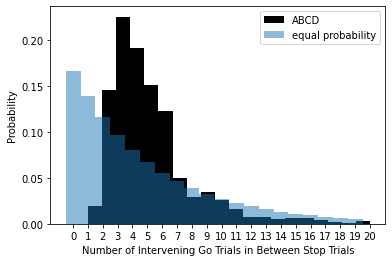

In [47]:
plt.hist(SST_concat['Stop_nback'].loc[stop_prob_index].dropna(), density = True, bins = 20, label = 'ABCD', color = 'black')
p_norm = p/np.sum(p)  # norm to sum=1
h = np.histogram(p_samp, bins = x, density=True)
plt.bar(h[1][:20],h[0][:20] , label = 'equal probability', alpha=0.5,width=1)
plt.xlabel('Number of Intervening Go Trials in Between Stop Trials')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 21, step=1))
plt.legend()
plt.savefig('conditional_probability.png', dpi=300)
plt.show()


conditional probability of a stop signal, given a stop signal occured two trials ago

In [48]:
def mean_nback(df, num_back): 
    stop_prob_index = df.loc[(df['StopTrial'] !=1) & (df['StopTrial'] !=31)].index
    df = df.loc[stop_prob_index]
    nback_proportion =len(df.loc[df['Stop_nback'] == num_back]) / len(df.loc[df['trial_type'] == 'StopTrial'])
    return nback_proportion

In [49]:
mean_one_nback = group_narguid.apply(lambda x: mean_nback(x, 1))
np.mean(mean_one_nback)

0.018030605773036296

In [50]:
#how many trials exist 
mean_zero_back = group_narguid.apply(lambda x: mean_nback(x, 0))
np.mean(mean_zero_back)

0.0

In [51]:
one_back = SST_concat.loc[SST_concat['Stop_nback'] == 1] #stop nback in this case 
stop_nback = SST_concat.loc[~SST_concat['Stop_nback'].isnull()]['Stop_nback']
print("percent of trials with stop signals sepreated by one go trial:", len(one_back) / len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'] )) 
#this num changed when re-ran with better indexing for selecting stop trials 

percent of trials with stop signals sepreated by one go trial: 0.021472364357165905


In [52]:
def calc_post_stop_slowing(df): 
    """
    1. calculates stop signal slowing for all trials 
    2. bins into quartiles 
    3. returns mean quartile signal slowing
    
    excludes  triplets that are seperated by sessions
    excludes triplets where there was an incorrect go choice response  for either go trial
    excludes triplets where there was an ommission go trial for either go trial
    """
    stop_slowing_df = pd.DataFrame()

    stop_mask = df.loc[df['trial_type'] == 'StopTrial']
    stop_idx = stop_mask[stop_mask == True].index

    df['correct_go_response'].replace('omission', np.NaN, inplace=True)
    df['correct_go_response'].replace('0.0', np.NaN, inplace=True)
    #get the pre-stop rt
    stop_slowing_df['StopTrial'] = df['StopTrial'][stop_idx]
    stop_slowing_df['TrialNum'] = df['TrialNum'][stop_idx]    

    stop_slowing_df['pre_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx - 1]) #find trial before stop signal
    stop_slowing_df['pre_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx - 1]) #find trial before stop signal


    stop_slowing_df['post_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_minus_pre'] = stop_slowing_df['post_stop_rt'] - stop_slowing_df['pre_stop_rt']
    
    #trial num 1 is left out because that triplet wouldn't have a pre-stop go trial
    first_quartile_mean = np.mean(stop_slowing_df.iloc[:15].loc[(stop_slowing_df['TrialNum'] != 1)].dropna(how='any')['post_minus_pre'])
    #trial num 180 is left out because that triplet wouldn't have a post-stop go trial 
    second_quartile_mean = np.mean(stop_slowing_df.iloc[15:30].loc[(stop_slowing_df['TrialNum'] != 180)].dropna(how='any')['post_minus_pre'])
    #trial num 180 and 181 are left out 
    third_quartile_mean = np.mean(stop_slowing_df.iloc[30:45].loc[(stop_slowing_df['TrialNum'] != 180) & (stop_slowing_df['TrialNum'] != 181)].dropna(how='any')['post_minus_pre'])
    #trial 360 is left out 
    fourth_quartile_mean = np.mean(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != 360)].iloc[45:60].dropna(how='any')['post_minus_pre'])
 
    quartile_list =[first_quartile_mean, second_quartile_mean, third_quartile_mean, fourth_quartile_mean]
 #below is useful for debugging, but otherwise slows down the code 
    #     trial_list = [len(stop_slowing_df.iloc[:15].loc[(stop_slowing_df['TrialNum'] != 1)].dropna(how='any')['post_minus_pre']),
#                   len(stop_slowing_df.iloc[15:30].loc[(stop_slowing_df['TrialNum'] != 180)].dropna(how='any')['post_minus_pre']),
#                  len(stop_slowing_df.iloc[30:45].loc[(stop_slowing_df['TrialNum'] != 180) & (stop_slowing_df['TrialNum'] != 181)].dropna(how='any')['post_minus_pre']),
#                  len(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != 360)].iloc[45:60].dropna(how='any')['post_minus_pre'])]

    return quartile_list #, trial_list

In [53]:
#this takes ~10 minutes to run 
quartile = group_narguid.apply(lambda x: calc_post_stop_slowing(x))

/Users/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [54]:
## this makes quartile to a dataframe and saves it - helpful if you accidently change quartile
quartile_df = pd.DataFrame(quartile)
quartile_df.columns = ['quartile_list']
quartile_df = pd.DataFrame(quartile_df.quartile_list.tolist(), index=quartile_df.index)
quartile_df.columns = ['quartile_1', 'quartile_2', 'quartile_3', 'quartile_4']
quartile_df.to_csv('quartile_df.csv')

In [55]:
quartile_df = pd.read_csv('quartile_df.csv') #for if you don't want to run that loop 

In [56]:
#take means of means 
post_stop_means = [np.nanmean(quartile_df['quartile_1']), np.nanmean(quartile_df['quartile_2']), 
                            np.nanmean(quartile_df['quartile_3']), np.nanmean(quartile_df['quartile_4'])]

In [57]:
#calc SEM for error bars 
post_stop_sem = [stats.sem(quartile_df['quartile_1'], nan_policy='omit'), stats.sem(quartile_df['quartile_2'], nan_policy='omit'), 
                 stats.sem(quartile_df['quartile_3'], nan_policy='omit'), stats.sem(quartile_df['quartile_4'], nan_policy='omit')]

##### Figure 6. Post-stop-signal slowing across the four quantiles of the ABCD stopping data. 


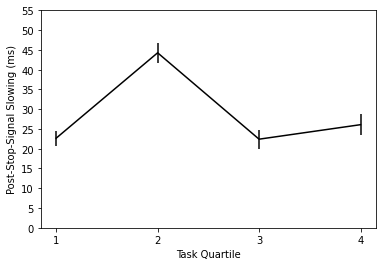

In [58]:
plt.errorbar(np.arange(1, 5, 1), post_stop_means, 
             yerr=[1.96 * i for i in post_stop_sem], color='black') 
#plt.title('Post-Stop-Trial Slowing')
plt.ylabel('Post-Stop-Signal Slowing (ms)')
plt.xlabel('Task Quartile')
plt.xticks([1, 2, 3, 4])
plt.yticks(np.arange(0,60,5))
plt.savefig('task_quartile_slowing.png', dpi=300)
plt.show() #needs error bars?  


### Issue 6: Trial accuracy incorrectly coded

There are some trials thave have the incorrect coding in TrialCode, and other accuracy columns. 

In [59]:
len(SST_concat.loc[(SST_concat['correct_stop'] == '1.0') & (SST_concat['TrialCode'] == 'IncorrectStop')])

/Users/work/anaconda3/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0

In [60]:
len(SST_concat.loc[(SST_concat['correct_go_response'] == '0.0') & (SST_concat['TrialCode'] == 'CorrectGo')])

49546

In [61]:
len(SST_concat.loc[(SST_concat['correct_go_response'] == '1.0') & (SST_concat['TrialCode'] == 'IncorrectGo')] ) 

10

In [62]:
len(SST_concat.loc[(SST_concat['correct_stop'] == 0) & (SST_concat['TrialCode'] == 'CorrectStop')])

911

### Issue 7: SSD values start too short 

SSD always start at 50ms, and it takes several trials to stabilize with a staircase tracking procedure. 

In [63]:
SST_concat.loc[SST_concat['StopTrial'] == 1]['SSDDur'].unique()

array([50.])

In [64]:
SST_concat.loc[SST_concat['StopTrial'] ==1]['correct_stop'].value_counts()

1.0    5439
0.0    1792
Name: correct_stop, dtype: int64

In [65]:
def binomial_CI(p, n, ci):  
    sem = math.sqrt(p * (1-p) / n)
    z = stats.norm.ppf(1-(1-ci)/2) #to get two tailed
    lower = p - (1.96 * sem)
    upper = p + (1.96 * sem)
    return upper, lower


In [66]:
#create a df with accuracy and ssd for each stop trial num 
num_stop = []
accuracy = [] 
mean_ssd = [] 
ssd_standard_error = []
acc_ci_upper = [] 
acc_ci_lower = []
for i in np.arange(1, 61): 
    correct = SST_concat.loc[SST_concat['StopTrial'] ==i]['correct_stop'].value_counts()[1]
    num_trials = len(SST_concat.loc[SST_concat['StopTrial'] ==i])#this takes the count of 1s
    acc = correct / len(SST_concat.loc[SST_concat['StopTrial'] ==i])
#     lower = astropy.stats.binom_conf_interval(correct, len(SST_concat.loc[SST_concat['StopTrial'] ==i]), .95)[0]
#     upper = astropy.stats.binom_conf_interval(correct, len(SST_concat.loc[SST_concat['StopTrial'] ==i]), .95)[1]
    
    acc_upper, acc_lower  = binomial_CI(acc, num_trials, .95)
    ssd_sem = stats.sem(SST_concat.loc[SST_concat['StopTrial'] == i]['SSDDur'])
    ssd = np.mean(SST_concat.loc[SST_concat['StopTrial'] == i]['SSDDur'])
    num_stop.append(i)
    accuracy.append(acc)
    ssd_standard_error.append(ssd_sem)
    mean_ssd.append(ssd)
    acc_ci_lower.append(acc_upper)
    acc_ci_upper.append(acc_lower)
    
acc_df = pd.DataFrame() 
acc_df['StopTrial'] = num_stop 
acc_df['Accuracy'] = accuracy
acc_df['SSD'] = mean_ssd
acc_df['ssd_standard_error'] = ssd_standard_error
acc_df['upper'] = acc_ci_upper
acc_df['lower'] = acc_ci_lower



####  Figure 7: Average stop-signal accuracy (a) and stop-signal delay (SSD, b) across subjects for each of the 60 stop trials.


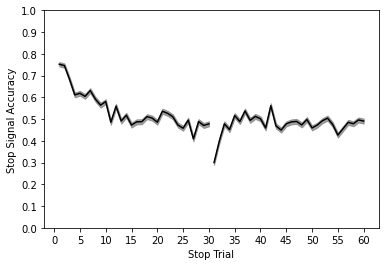

In [67]:
plt.plot(acc_df['StopTrial'][:30], acc_df['Accuracy'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['Accuracy'][30:], color='black')


plt.fill_between(x=acc_df['StopTrial'][:30], y1=acc_df['lower'][:30], 
                 y2=acc_df['upper'][:30], color='grey', alpha=.75)

plt.fill_between(x=acc_df['StopTrial'][30:], y1=acc_df['lower'][30:], 
                 y2=acc_df['upper'][30:], color='grey', alpha=.75)

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Accuracy')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.yticks(np.arange(0,1.1, .1))
plt.xticks(np.arange(0,61,5))
plt.savefig('stop_signal_accuracy_across_stop_trial.png', dpi=300)
plt.show() #needs error bars 


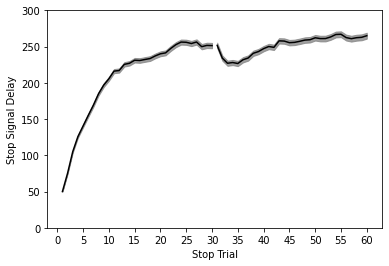

In [68]:
plt.plot(acc_df['StopTrial'][:30], acc_df['SSD'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['SSD'][30:], color='black')
plt.fill_between(x=acc_df['StopTrial'][:30], y1=acc_df['SSD'][:30]-(1.96*acc_df['ssd_standard_error'][:30]), 
                 y2=acc_df['SSD'][:30]+(1.96*acc_df['ssd_standard_error'][:30]), color='grey', alpha=.75
                            )

plt.fill_between(x=acc_df['StopTrial'][30:], y1=acc_df['SSD'][30:]-(1.96*acc_df['ssd_standard_error'][30:]), 
                                           y2=acc_df['SSD'][30:]+(1.96*acc_df['ssd_standard_error'][30:]), color='grey',
                alpha=.75)
plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Delay')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
plt.xticks(np.arange(0,61,5))
plt.yticks(np.arange(0, 350, 50))
plt.savefig('ssd_across_stop_trial.png', dpi=300)
plt.show()


#### Issue 8: Low stop probability 

The probabilty of a stop trial is .167. 

In [69]:
len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])/ len(SST_concat)

0.16666666666666666